# GTZAN_images_1_LogisticRegression_SVC_LightGBM_DTC_KNN
---

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import image
%matplotlib inline
from skimage import io
from skimage.feature import hog
from skimage.transform import rescale

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV, RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

from lightgbm import LGBMClassifier

In [2]:
genres = ['hiphop', 'disco', 'metal', 'reggae', 'jazz', 'rock', 'blues', 'pop', 'classical', 'country']

In [3]:
# filename example: blues.00000.wav - blues.00099.wav (100 wav files for each genre)
# numbers: 00000 - 00099
# format: wav (audio)
# filename = {genre}. + number + .wav

# generate filenumbers (eg '00001.wav')
numrange = range(0,100)
filenums = []

for num in numrange:
    if num < 10:
        filenums.append('0000'+str(num)+'.wav')
    else:
        filenums.append('000'+str(num)+'.wav')
        
print(filenums[:3], filenums[-3:])

['00000.wav', '00001.wav', '00002.wav'] ['00097.wav', '00098.wav', '00099.wav']


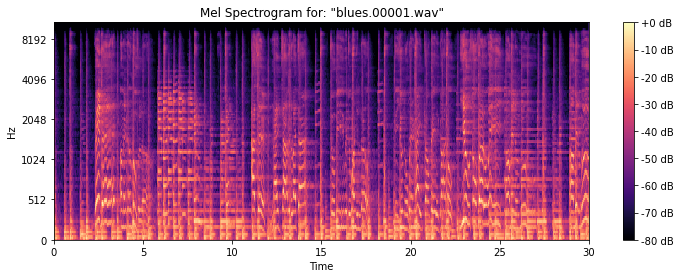

In [12]:
genre = 'blues'
filename = 'blues.00001.wav'
filepath = f'../gtzan/Data/genres_original/{genre}/{filename}'

# loading audio
y, sr = librosa.load(filepath)

#Mel Spectogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# convert to log scale (dB), using peak power (max) as reference
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))

# display spectogram on a mel scale
# sample rate and hop length parameters used to render time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.f dB")

plt.title('Mel Spectrogram for: "blues.00001.wav"')

plt.show()

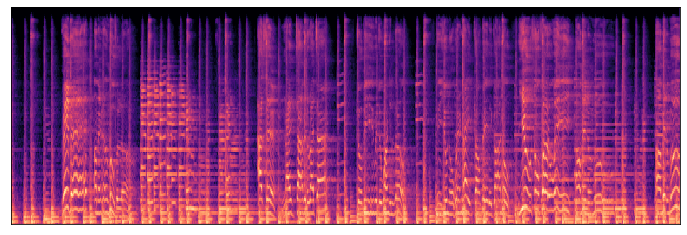

In [13]:
genre = 'blues'
filename = 'blues.00001.wav'
filepath = f'../gtzan/Data/genres_original/{genre}/{filename}'

# loading audio
y, sr = librosa.load(filepath)

#Mel Spectogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

# convert to log scale (dB), using peak power (max) as reference
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12,4))

# display spectogram on a mel scale
# sample rate and hop length parameters used to render time axis
librosa.display.specshow(log_S, sr=sr)#, x_axis='time', y_axis='mel')

plt.savefig('../gtzan/lib_images/lib_specgrams/blues_spec_example_3.png')


# Generate spectrograms and save to file

In [5]:
# iterate through wav files, process spectrograms with librosa, save images to another directory: lib_specgrams
for genre in genres:
    for num in filenums:
        filename_wav = genre+'.'+num 
        
        filepath = f'../gtzan/Data/genres_original/{genre}/{filename_wav}'
#        print(filepath)
        print(f'{genre}{num[:-4]}_spec.png')
        
        try:        
            # loading audio
            y, sr = librosa.load(filepath)

            #Mel Spectogram
            S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

            # convert to log scale (dB), using peak power (max) as reference
            log_S = librosa.power_to_db(S, ref=np.max)

            plt.figure(figsize=(12,4))

            # display spectogram on a mel scale
            # sample rate and hop length parameters used to render time axis
            librosa.display.specshow(log_S, sr=sr)#, x_axis='time', y_axis='mel')
            
            # write to disk
            plt.savefig(f'../gtzan/lib_images/lib_specgrams/{genre}{num[:-4]}_spec.png')

        except:
            continue

In [8]:
# populate images_dict with filename and accompanying np array, representing the associated image
images_dict = {}

# cycle through spectrograms, add to images_dict
for genre in genres:
    for num in filenums:
        filepath = f'../gtzan/lib_images/lib_specgrams/{genre}{num[:-4]}_spec.png'        
        
        try:
            images_dict[f'{genre}{num[:-4]}'] = io.imread(filepath)
        except:
            continue
            
# images_dict will have following fomat:
# {'hiphop00000': array([[[255, 255, 255, 255],
#          [255, 255, 255, 255],
#          [255, 255, 255, 255],
#          ...,
#          [255, 255, 255, 255],
#          [255, 255, 255, 255],
#          [255, 255, 255, 255]],

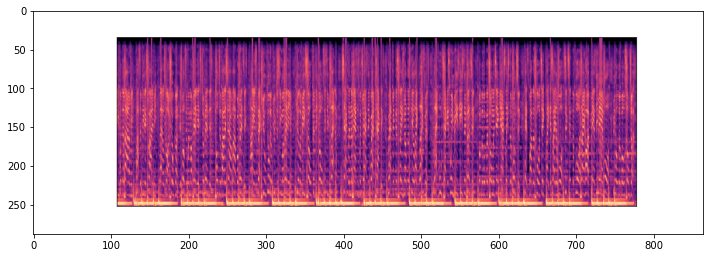

In [9]:
# each plot has a white border
fig, ax = plt.subplots(1,1, figsize=(12,12))
plt.imshow(images_dict['hiphop00001'])
plt.show()

In [10]:
# crop white borders out of each image and "standardize"
cropped_dict = {}

for genre in genres:
    for num in filenums:
        try: # jazz00054 was missing. Could be others too. And "standardize" (divide 255)
            cropped_dict[genre+num[:-4]] = images_dict[genre+num[:-4]][35:253,108:779] / 255
        except:
            continue
            
# cropped_dict will have following format:
#     {'hiphop00000': array([[[0.01176471, 0.00392157, 0.02745098, 1.        ],
#          [0.        , 0.        , 0.        , 1.        ],
#          [0.        , 0.        , 0.        , 1.        ],
#          ...,
#          [0.        , 0.        , 0.        , 1.        ],
#          [0.        , 0.        , 0.        , 1.        ],
#          [0.0745098 , 0.0745098 , 0.0745098 , 1.        ]],

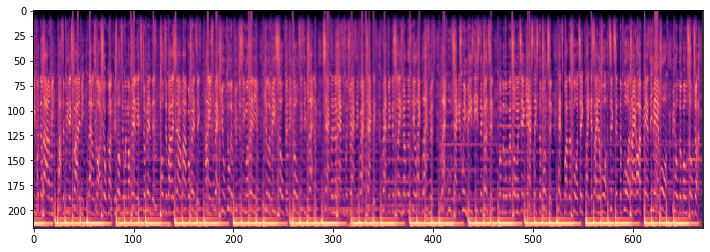

In [11]:
# white border cropped
fig, ax = plt.subplots(1,1, figsize=(12,12))
plt.imshow(cropped_dict['hiphop00001'])
plt.show()

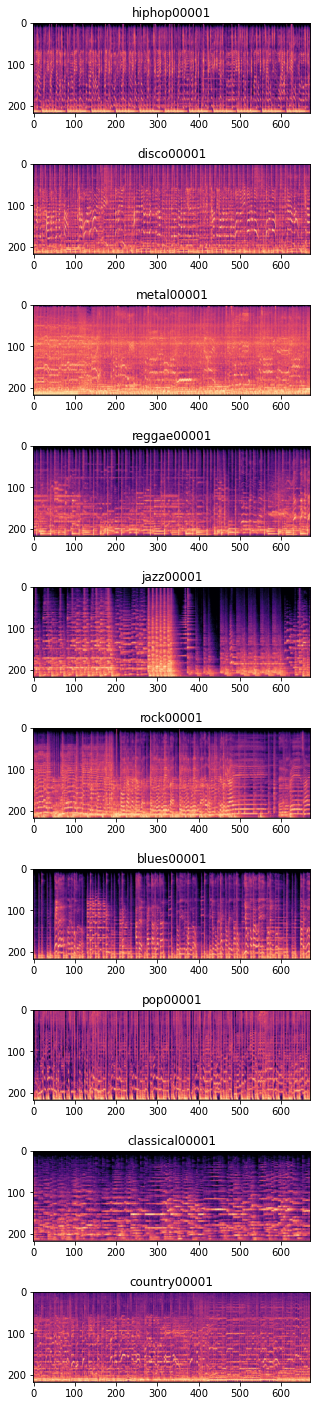

In [12]:
# spectrogram example for each genre
fig, ax = plt.subplots(10,1, figsize=(12,20))
plt.tight_layout(pad=3)

for i, genre in zip(range(10), genres):
    
    ax[i].imshow(cropped_dict[genre+'00001'])
    ax[i].set_title(genre+'00001')

plt.show()

In [18]:
print('Shape of one track array: ', cropped_dict['hiphop00000'].shape)
cropped_dict['hiphop00000']

Shape of one track array:  (218, 671, 4)


array([[[0.01176471, 0.00392157, 0.02745098, 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        ...,
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.0745098 , 0.0745098 , 0.0745098 , 1.        ]],

       [[0.03529412, 0.01176471, 0.0745098 , 1.        ],
        [0.        , 0.        , 0.01568627, 1.        ],
        [0.        , 0.        , 0.01568627, 1.        ],
        ...,
        [0.        , 0.        , 0.01568627, 1.        ],
        [0.        , 0.        , 0.01568627, 1.        ],
        [0.2       , 0.2       , 0.2       , 1.        ]],

       [[0.03529412, 0.01176471, 0.0745098 , 1.        ],
        [0.        , 0.        , 0.01568627, 1.        ],
        [0.        , 0.        , 0.01568627, 1.        ],
        ...,
        [0.        , 0.        , 0.01568627, 1.        ],
        [0.        , 0.      

# df_flat dataframe

In [21]:
# flatten all 3D arrays (images) to 1D
flat_dict = {}

for key in cropped_dict:
#     print(key+'_flat')
    flat_dict[key+'_flat'] = cropped_dict[key].ravel() # .ravel(order='F')
    
df_flat = pd.DataFrame(flat_dict).T

print('df_flat shape: ', df_flat.shape)
display(df_flat.head(3))
display(df_flat.tail(3))

df_flat shape:  (992, 585112)


,0,1,2,3,4,5,6,7,8,9,...,585102,585103,585104,585105,585106,585107,585108,585109,585110,585111
hiphop00000_flat,0.011765,0.003922,0.027451,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.2,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0
hiphop00001_flat,0.003922,0.003922,0.015686,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.2,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0
hiphop00002_flat,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.2,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0


,0,1,2,3,4,5,6,7,8,9,...,585102,585103,585104,585105,585106,585107,585108,585109,585110,585111
country00097_flat,0.000000,0.000000,0.007843,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.2,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0
country00098_flat,0.007843,0.003922,0.023529,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.2,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0
country00099_flat,0.003922,0.003922,0.019608,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.2,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0


In [22]:
# add column for label ('genre'), then slice filenumber off
df_flat['genre'] = df_flat.index
df_flat['genre'] = df_flat['genre'].apply(lambda x: x[:-10])

print('df_flat shape: ', df_flat.shape)
display(df_flat.head(3))

df_flat shape:  (992, 585113)


,0,1,2,3,4,5,6,7,8,9,...,585103,585104,585105,585106,585107,585108,585109,585110,585111,genre
hiphop00000_flat,0.011765,0.003922,0.027451,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0,hiphop
hiphop00001_flat,0.003922,0.003922,0.015686,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0,hiphop
hiphop00002_flat,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.2,0.2,0.2,1.0,0.07451,0.07451,0.07451,1.0,hiphop


# df_hog dataframe (HOG features)

In [23]:
# function to return hog features
def hog_features(image):
    image_hog = hog(
    image=image, pixels_per_cell=(12, 12),
    cells_per_block=(12,12),
    orientations=8,
    visualize=False,
    block_norm='L2-Hys', feature_vector=True)
    
    return image_hog

In [24]:
# populate dict for hog features
hog_dict = {}

for genre in genres:
    for num in filenums:
        try: # jazz00054 was missing. 
            hog_dict[genre+num[:-4]] = hog_features(cropped_dict[genre+num[:-4]])                
        except:
            continue

In [27]:
# create df with hog features
df_hog = pd.DataFrame(hog_dict).T

print('df_hog shape: ', df_hog.shape)
display(df_hog.head(3))
display(df_hog.tail(3))

df_hog shape:  (992, 354816)


,0,1,2,3,4,5,6,7,8,9,...,354806,354807,354808,354809,354810,354811,354812,354813,354814,354815
hiphop00000,0.018938,0.010605,0.012612,0.018360,0.032943,0.010784,0.011244,0.012015,0.038173,0.027148,...,0.029885,0.059590,0.088369,0.013351,0.000759,0.004912,0.009615,0.004138,0.027373,0.123135
hiphop00001,0.031128,0.019940,0.013632,0.006903,0.013619,0.003466,0.026502,0.018502,0.021324,0.017315,...,0.008686,0.018755,0.012975,0.007600,0.009196,0.040612,0.070642,0.011856,0.007087,0.009830
hiphop00002,0.002639,0.006048,0.005898,0.005635,0.016218,0.010080,0.002539,0.002379,0.018883,0.002200,...,0.006190,0.010706,0.040775,0.027756,0.011411,0.018062,0.027115,0.011233,0.015448,0.021675


,0,1,2,3,4,5,6,7,8,9,...,354806,354807,354808,354809,354810,354811,354812,354813,354814,354815
country00097,0.017001,0.006026,0.005138,0.000796,0.012003,0.006879,0.007929,0.009079,0.056912,0.024703,...,0.001748,0.002880,0.001616,0.002160,0.004341,0.023219,0.071308,0.006470,0.001584,0.000888
country00098,0.009904,0.002969,0.001155,0.000000,0.005266,0.002636,0.001743,0.003017,0.040535,0.004774,...,0.015802,0.046401,0.002098,0.006745,0.019063,0.097700,0.117850,0.006059,0.007043,0.000000
country00099,0.040117,0.009936,0.015179,0.007374,0.019157,0.032571,0.028070,0.007749,0.022049,0.028739,...,0.050069,0.063221,0.029752,0.019786,0.036605,0.040045,0.034504,0.030133,0.032711,0.061813


In [28]:
# add column for label ('genre'), then slice filenumber off
df_hog['genre'] = df_hog.index
df_hog['genre'] = df_hog['genre'].apply(lambda x: x[:-5])

print('df_hog shape: ', df_hog.shape)
display(df_hog.head(3))

df_hog shape:  (992, 354817)


,0,1,2,3,4,5,6,7,8,9,...,354807,354808,354809,354810,354811,354812,354813,354814,354815,genre
hiphop00000,0.018938,0.010605,0.012612,0.018360,0.032943,0.010784,0.011244,0.012015,0.038173,0.027148,...,0.059590,0.088369,0.013351,0.000759,0.004912,0.009615,0.004138,0.027373,0.123135,hiphop
hiphop00001,0.031128,0.019940,0.013632,0.006903,0.013619,0.003466,0.026502,0.018502,0.021324,0.017315,...,0.018755,0.012975,0.007600,0.009196,0.040612,0.070642,0.011856,0.007087,0.009830,hiphop
hiphop00002,0.002639,0.006048,0.005898,0.005635,0.016218,0.010080,0.002539,0.002379,0.018883,0.002200,...,0.010706,0.040775,0.027756,0.011411,0.018062,0.027115,0.011233,0.015448,0.021675,hiphop


# LogReg (PCA on original pixel features, ie. PC of df_flat)

In [29]:
# set target and features
X = df_flat.copy()
y = X.pop('genre')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1, shuffle=True)

# No standardisation as the data is already between 0 (black) and 1 (full colour -RGB- or intensity)

In [30]:
# # logreg on flattened 
# lr = LogisticRegression(max_iter=10000)
# lr.fit(X_train, y_train)

# train_score_log = lr.score(X_train, y_train)
# cv_mean_log = cross_val_score(lr, X_train, y_train, cv=5).mean()
# test_score_log = lr.score(X_test, y_test)

# print('LogReg: no regularisation (PC features)')
# print()
# print('train score:\t', train_score_log)
# print('cv mean:\t', cv_mean_log)
# print('test score:\t', test_score_log)

In [40]:
# PCA (n_components: 0.99999999)
n_components = 0.99999999
pca = PCA(n_components=n_components, random_state=1, svd_solver='full')
X_train_pc = pd.DataFrame(pca.fit_transform(X_train), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_train.index)

X_test_pc = pd.DataFrame(pca.transform(X_test), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_test.index)

display(X_train_pc.head(3))
print('PCA explained variance ratio cumulative sum:')
print('Length: ', len(pca.explained_variance_ratio_.cumsum()))
print()
print(pca.explained_variance_ratio_.cumsum()[:20])
print('...')
print(pca.explained_variance_ratio_.cumsum()[-20:])

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_774,PC_775,PC_776,PC_777,PC_778,PC_779,PC_780,PC_781,PC_782,PC_783
jazz00095_flat,35.945405,0.057807,23.398071,-5.038409,-15.836764,0.273446,-2.334707,7.343592,7.213397,8.454673,...,0.103032,0.255788,-0.045508,-0.153268,-0.007589,-0.023265,0.016702,0.009150,0.002185,-0.001488
country00045_flat,-47.742703,20.922784,-19.263673,-3.249992,7.739149,10.576791,2.492374,3.987026,-6.823568,-3.793118,...,0.322264,-0.186630,0.078468,-0.069106,0.009483,0.008541,0.005712,-0.012372,-0.002046,-0.002269
jazz00094_flat,118.635285,-6.432767,10.082338,0.906909,10.692720,-8.559497,-7.539134,-3.097323,5.692915,9.763008,...,-0.011091,-0.101238,-0.063482,0.087436,-0.027884,-0.001060,-0.009912,-0.001346,0.000499,0.002260


PCA explained variance ratio cumulative sum:
Length:  783

[0.31009319 0.36914754 0.39387783 0.4135305  0.42888525 0.43982127
 0.44957903 0.45685798 0.46336513 0.46904032 0.47405873 0.47877701
 0.48346863 0.48800775 0.49235532 0.49633592 0.50005446 0.50371418
 0.50708413 0.51028056]
...
[0.99795145 0.99813294 0.99831357 0.99849199 0.99866888 0.99884213
 0.99901473 0.99918541 0.99934973 0.99950968 0.99966002 0.99979135
 0.99987646 0.99994891 0.99996803 0.99997986 0.99998936 0.99999451
 0.99999844 1.        ]


X_train_pc shape: (793, 783)


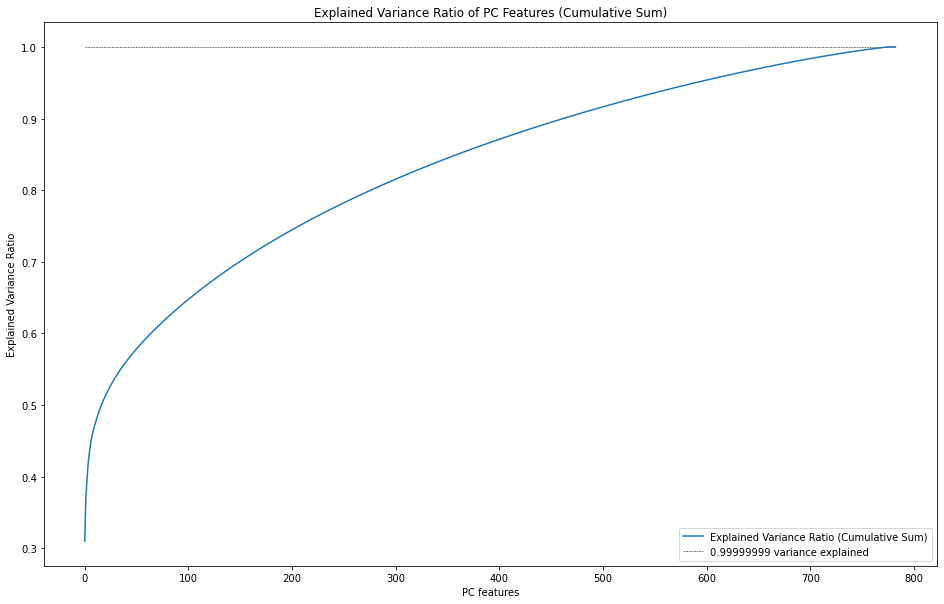

In [41]:
print('X_train_pc shape:', X_train_pc.shape)

fig, ax = plt.subplots(1,1, figsize=(16,10))

# plot explained variance ratio cumulative sum of principle components
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Explained Variance Ratio (Cumulative Sum)')

# plot horizontal line at required explained variance, ie n_components = 0.99999999
plt.hlines(y=n_components, xmin=0, xmax=len(pca.explained_variance_ratio_), colors='k', linestyles='dashed', lw=0.5, label=f'{n_components} variance explained', data=None)
plt.legend(loc='lower right')
plt.xlabel('PC features')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of PC Features (Cumulative Sum)')
plt.show()

In [25]:
# logreg on PC of flattened array
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_pc, y_train)

train_score_log = lr.score(X_train_pc, y_train)
cv_mean_log = cross_val_score(lr, X_train_pc, y_train, cv=5).mean()
test_score_log = lr.score(X_test_pc, y_test)

print('LogReg: no regularisation (PC features)')
print()
print('train score:\t', train_score_log)
print('cv mean:\t', cv_mean_log)
print('test score:\t', test_score_log)

LogReg: no regularisation (PC features)

train score:	 0.9987484355444305
cv mean:	 0.5506682389937108
test score:	 0.57


# LogReg (PCA on HOG features, ie. PC of df_hog)

In [42]:
# set target and features
X = df_hog.copy()
y = X.pop('genre')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1, shuffle=True)

# No standardisation as the data is already between 0 (black) and 1 (full colour -RGB- or intensity)

In [ ]:
# # logreg on flattened 
# lr = LogisticRegression(max_iter=10000)
# lr.fit(X_train, y_train)

# train_score_log = lr.score(X_train, y_train)
# cv_mean_log = cross_val_score(lr, X_train, y_train, cv=5).mean()
# test_score_log = lr.score(X_test, y_test)

# print('LogReg: no regularisation (PC features)')
# print()
# print('train score:\t', train_score_log)
# print('cv mean:\t', cv_mean_log)
# print('test score:\t', test_score_log)

In [45]:
# PCA (n_components: 0.99999999)
n_components = 0.99999999
pca = PCA(n_components=n_components, random_state=1, svd_solver='full')
X_train_pc = pd.DataFrame(pca.fit_transform(X_train), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_train.index)

X_test_pc = pd.DataFrame(pca.transform(X_test), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_test.index)

display(X_train_pc.head(3))
print('PCA explained variance ratio cumulative sum:')
print('Length: ', len(pca.explained_variance_ratio_.cumsum()))
print()
print(pca.explained_variance_ratio_.cumsum()[:20])
print('...')
print(pca.explained_variance_ratio_.cumsum()[-20:])

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_774,PC_775,PC_776,PC_777,PC_778,PC_779,PC_780,PC_781,PC_782,PC_783
jazz00095,5.599659,-0.694797,0.885521,-0.067306,-0.104852,-1.502558,0.980847,0.882049,-0.744869,-0.548750,...,0.043330,0.007483,-0.002646,0.022760,-0.000771,-0.002432,0.002488,0.000640,-0.000975,-0.000661
country00045,-0.418252,0.323445,-1.561104,0.395270,0.460257,0.457815,-0.570483,-0.463616,0.292842,-0.196589,...,-0.065450,0.026097,0.022780,0.007522,-0.001256,0.000223,0.000274,-0.000716,-0.000796,0.000906
jazz00094,2.506571,2.623898,0.696892,-0.672681,-0.803996,-0.345899,-0.008257,0.222310,-0.396406,1.053514,...,-0.008671,0.015936,-0.017101,0.048287,0.001281,-0.000244,-0.001498,-0.000558,0.001194,0.000596


PCA explained variance ratio cumulative sum:
Length:  783

[0.26645025 0.30376505 0.33027691 0.34327627 0.35564099 0.36523631
 0.37390263 0.38150711 0.38881276 0.39572359 0.40233405 0.40877245
 0.41490078 0.4208758  0.4267389  0.43247928 0.43786559 0.44308118
 0.44822736 0.45335262]
...
[0.9983502  0.99849603 0.99864038 0.99878256 0.99892317 0.99906003
 0.99919621 0.99932691 0.99945029 0.99956923 0.9996808  0.99977389
 0.99986441 0.99995031 0.99996258 0.99997213 0.999981   0.99998832
 0.99999444 1.        ]


X_train_pc shape: (793, 783)


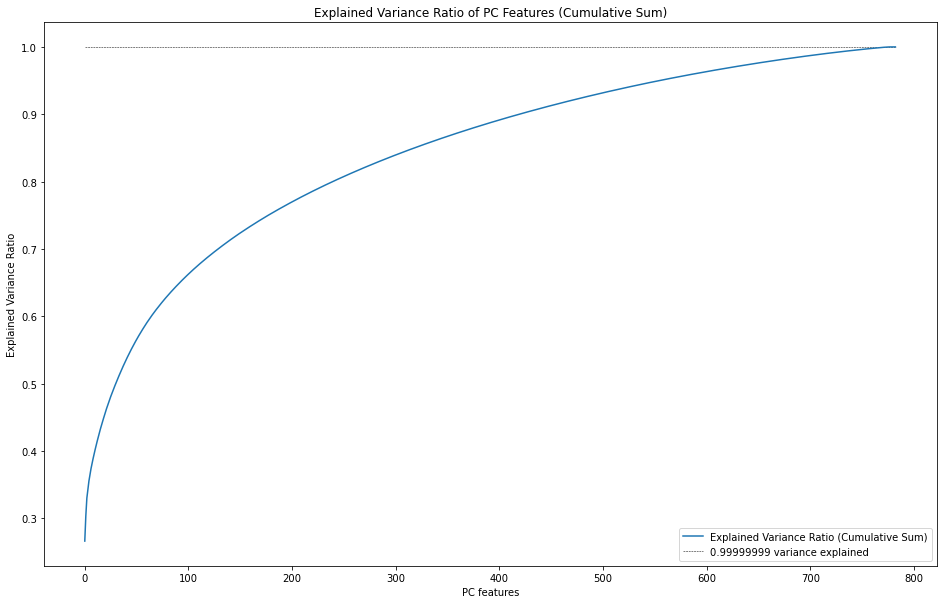

In [47]:
print('X_train_pc shape:', X_train_pc.shape)

fig, ax = plt.subplots(1,1, figsize=(16,10))

# plot explained variance ratio cumulative sum of principle components
plt.plot(pca.explained_variance_ratio_.cumsum(), label='Explained Variance Ratio (Cumulative Sum)')

# plot horizontal line at required explained variance, ie n_components = 0.99999999
plt.hlines(y=n_components, xmin=0, xmax=len(pca.explained_variance_ratio_), colors='k', linestyles='dashed', lw=0.5, label=f'{n_components} variance explained', data=None)
plt.legend(loc='lower right')
plt.xlabel('PC features')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of PC Features (Cumulative Sum)')
plt.show()

# LogReg (hog PC)

In [33]:
# logreg on flattened hog
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_pc, y_train)

train_score_log = lr.score(X_train_pc, y_train)
cv_mean_log = cross_val_score(lr, X_train_pc, y_train, cv=5).mean()
test_score_log = lr.score(X_test_pc, y_test)

print('LogReg: no regularisation (PC features)')
print()
print('train score:\t', train_score_log)
print('cv mean:\t', cv_mean_log)
print('test score:\t', test_score_log)

LogReg: no regularisation (PC features)

train score:	 0.9987484355444305
cv mean:	 0.5944732704402516
test score:	 0.65


In [36]:
lr_l2 = LogisticRegressionCV(
    Cs=np.logspace(-4,4,5),
    fit_intercept=True,
    cv=5,
#     dual=False,
    penalty='l2',
#     scoring=None,
    solver='lbfgs',
#     tol=0.0001,
    max_iter=10000,
    class_weight='balanced',
    n_jobs=-1,
    verbose=1,
#     refit=True,
#     intercept_scaling=1.0,
    multi_class='ovr',
    random_state=1,
    l1_ratios=None)

lr_l2.fit(X_train_pc, y_train)

print('LogReg: Ridge (HOG PC features)')
print()
print('train score:\t', lr_l2.score(X_train_pc, y_train))
print('cv mean:\t', cross_val_score(lr_l2, X_train_pc, y_train, cv=5).mean())
print('test score:\t', lr_l2.score(X_test_pc, y_test))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.7s finished


LogReg: Ridge (HOG PC features)

train score:	 0.9987484355444305


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Don

cv mean:	 0.4905738993710692
test score:	 0.525


# SVC (PC features)

In [56]:
svc = SVC(C=1.0,
    kernel='poly',
#     degree=3,
    gamma='auto',
#     coef0=0.0,
#     shrinking=True,
#     probability=False,
#     tol=0.001,
#     cache_size=200,
#     class_weight=None,
    verbose=True,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=1)

svc.fit(X_train_pc, y_train)

train_score_svc = svc.score(X_train_pc, y_train)
cv_mean_svc = cross_val_score(svc, X_train_pc, y_train, cv=10).mean()
test_score_svc = svc.score(X_test_pc, y_test)

print('SVC: PC features')
print()
print('train score:\t', train_score_svc)
print('cv mean:\t', cv_mean_svc)
print('test score:\t', test_score_svc)


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]SVC: PC features

train score:	 0.29912390488110135
cv mean:	 0.22908227848101265
test score:	 0.215


# LightGBM

In [60]:
lgb = LGBMClassifier()
lgb.fit(X_train_pc, y_train)

# scores
print('cv mean:\t', cross_val_score(lgb, X_train_pc, y_train, cv=5).mean())
print('train score:\t', lgb.score(X_train_pc, y_train))
print('test score:\t', lgb.score(X_test_pc, y_test))

cv mean:	 0.4668081761006289
train score:	 1.0
test score:	 0.545


In [71]:
lgb_forgrid = LGBMClassifier()

param_grid = {
#     boosting_type='gbdt',
    'num_leaves':[10,31,50],
    'max_depth':[10,50,500,-1],
    'learning_rate':np.logspace(-3,1,5),
    'n_estimators':[1000],
#     subsample_for_bin=200000,
#     objective=None,
    'class_weight':['balanced', None],
#     min_split_gain=0.0,
#     min_child_weight=0.001,
#     min_child_samples=20,
#     subsample=1.0,
#     subsample_freq=0,
#     colsample_bytree=1.0,
#     reg_alpha=0.0,
#     reg_lambda=0.0,
    'random_state':[1],
    'n_jobs':[-1],
#     silent=True,
#     importance_type='split'    
}

grid = GridSearchCV(estimator=lgb_forgrid, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
grid.fit(X_train_pc, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 125.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 255.7min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 268.7min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                         'max_depth': [10, 50, 500, -1], 'n_estimators': [1000],
                         'n_jobs': [-1], 'num_leaves': [10, 31, 50],
                         'random_state': [1]},
             verbose=1)

In [72]:
# scores
print('best params:\t', grid.best_params_)
print()
print('cv mean:\t', grid.best_score_)
print('train score:\t', grid.score(X_train_pc, y_train))
print('test score:\t', grid.score(X_test_pc, y_test))

best params:	 {'class_weight': None, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 50, 'random_state': 1}

cv mean:	 0.4793474842767296
train score:	 1.0
test score:	 0.53


In [75]:
grid.best_estimator_

LGBMClassifier(max_depth=10, n_estimators=1000, num_leaves=50, random_state=1)

In [76]:
grid.best_params_

{'class_weight': None,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 1000,
 'n_jobs': -1,
 'num_leaves': 50,
 'random_state': 1}

In [79]:
# save the model to disk
filename = 'grid_imageshog_lgbm.pkl'
pickle.dump(grid, open(filename, 'wb'))

In [81]:
# load the model from disk
grid_2 = pickle.load(open(filename, 'rb'))

In [82]:
grid_2.best_score_

0.4793474842767296

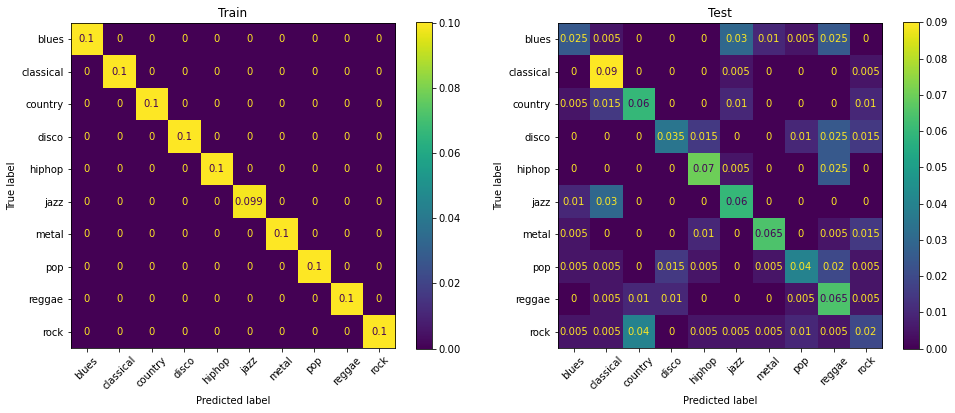

In [86]:
# confusion matrix
pred_train = grid.predict(X_train_pc)
pred_test = grid.predict(X_test_pc)
conf_matrix = confusion_matrix(y_train, pred_train)
#display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(grid, X_train_pc, y_train, ax=ax[0], xticks_rotation=45, normalize='all')
plot_confusion_matrix(grid, X_test_pc, y_test, ax=ax[1], xticks_rotation=45, normalize='all')
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [84]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     1.0000    1.0000    1.0000        80
   classical     1.0000    1.0000    1.0000        80
     country     1.0000    1.0000    1.0000        80
       disco     1.0000    1.0000    1.0000        80
      hiphop     1.0000    1.0000    1.0000        80
        jazz     1.0000    1.0000    1.0000        79
       metal     1.0000    1.0000    1.0000        80
         pop     1.0000    1.0000    1.0000        80
      reggae     1.0000    1.0000    1.0000        80
        rock     1.0000    1.0000    1.0000        80

    accuracy                         1.0000       799
   macro avg     1.0000    1.0000    1.0000       799
weighted avg     1.0000    1.0000    1.0000       799


Classification report: test set

              precision    recall  f1-score   support

       blues     0.4545    0.2500    0.3226        20
   classical     0.5806    0.9000    0.7059        20
     coun

In [87]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

In [88]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

In [89]:
proba_train = grid.predict_proba(X_train_pc)
proba_test = grid.predict_proba(X_test_pc)

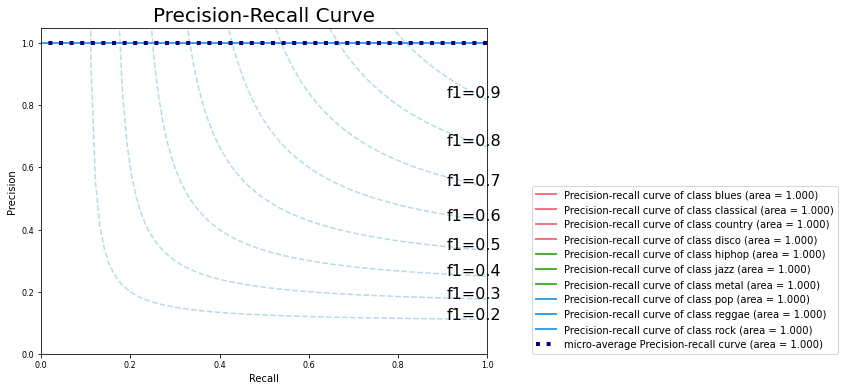

In [98]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_train, proba_train, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=8, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

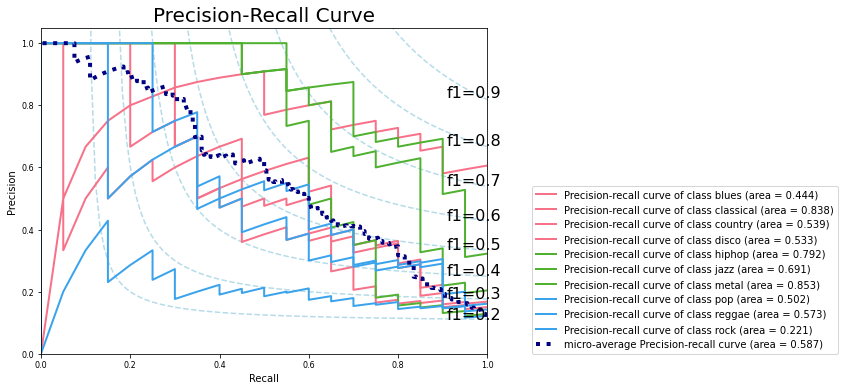

In [97]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, proba_test, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=8, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

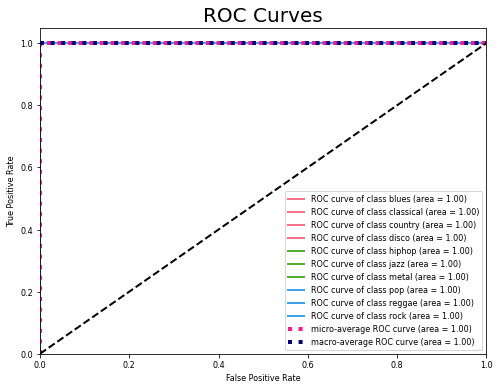

In [96]:
skplt.metrics.plot_roc(y_train, proba_train, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=8, figsize=(8,6), cmap=cmap)
plt.show()

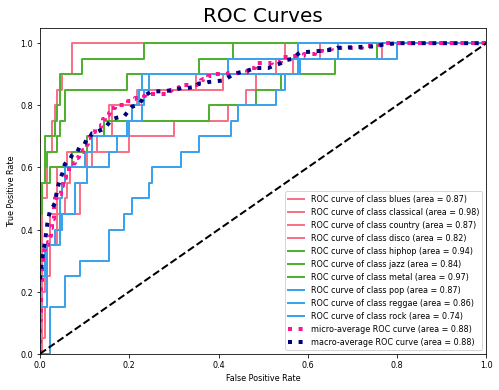

In [95]:
# ROC test
skplt.metrics.plot_roc(y_test, proba_test, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=8, figsize=(8,6), cmap=cmap)
plt.show()

# DTC

In [63]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train_pc, y_train)

# scores
print('cv mean:\t', cross_val_score(dtc, X_train_pc, y_train, cv=5).mean())
print('train score:\t', dtc.score(X_train_pc, y_train))
print('test score:\t', dtc.score(X_test_pc, y_test))

cv mean:	 0.3366194968553459
train score:	 0.9987484355444305
test score:	 0.37


# KNN

In [40]:
def knn_scores(data_train=X_train_pc, data_test=X_test_pc, 
               neighbors_min=1, neighbors_max=20, neighbors_increment=1):
    """
    fit and score for a range of knn
    """
    neighbors_range = range(neighbors_min, neighbors_max+1, neighbors_increment)
    train_scores_list = []
    test_scores_list = []
    cv_means_list = []

    for n_neighbors in neighbors_range:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(data_train, y_train)

        train_scores_list.append(knn.score(data_train, y_train))
        test_scores_list.append(knn.score(data_test, y_test))
        cv_means_list.append(cross_val_score(knn, data_train, y_train, cv=10).mean())

    df_knn_scores = pd.DataFrame({'n_neighbors':neighbors_range, 
                                 'train_scores':train_scores_list,
                                 'test_scores':test_scores_list,
                                 'cv_means':cv_means_list})

    df_knn_scores.set_index('n_neighbors', inplace=True)

    cv_means_max = df_knn_scores.cv_means.max()
    cv_means_max_neighbors = df_knn_scores[df_knn_scores.cv_means == df_knn_scores.cv_means.max()].index[0]
    print(f'CV means max: {cv_means_max}\nNeighbors: {cv_means_max_neighbors}')
    return df_knn_scores

In [41]:
# function to plot scores for varying knn
def knn_scores_plot(df):
    """
    plot scores for range of knn
    """
    cv_means_max = df.cv_means.max()
    cv_means_max_neighbors = df[df.cv_means == df.cv_means.max()].index[0]
    
    df.plot(figsize=(14,8))
    plt.vlines(x=cv_means_max_neighbors, 
               ymin=df.min().min(), ymax=df.max().max(), 
               colors='k', linestyles='dashed', lw=0.5, label='', data=None)
    plt.legend(loc = 'best')
    plt.xticks(range(df.index[0], df.index[-1], int((df.index[-1] - df.index[0]) / 20)+1))
    plt.title('Scores at Different K (KNN) for hog PC features')
    plt.xlabel('k neighbors')
    plt.ylabel('accuracy score');
    
    print(f'CV means max: {cv_means_max}\nNeighbors: {cv_means_max_neighbors}')

In [37]:
df_knn_scores = knn_scores(data_train=X_train_pc, data_test=X_test_pc, 
                           neighbors_min=1, neighbors_max=20, neighbors_increment=1)
df_knn_scores

CV means max: 0.29661392405063297
Neighbors: 15


,train_scores,test_scores,cv_means
n_neighbors,,,
1,1.000000,0.355,0.295443
2,0.605757,0.325,0.277927
3,0.484355,0.305,0.266614
4,0.436796,0.280,0.282880
5,0.389237,0.280,0.267911
6,0.397997,0.280,0.272911
7,0.382979,0.280,0.280459
8,0.369212,0.280,0.267927
9,0.361702,0.260,0.269130


CV means max: 0.29661392405063297
Neighbors: 15


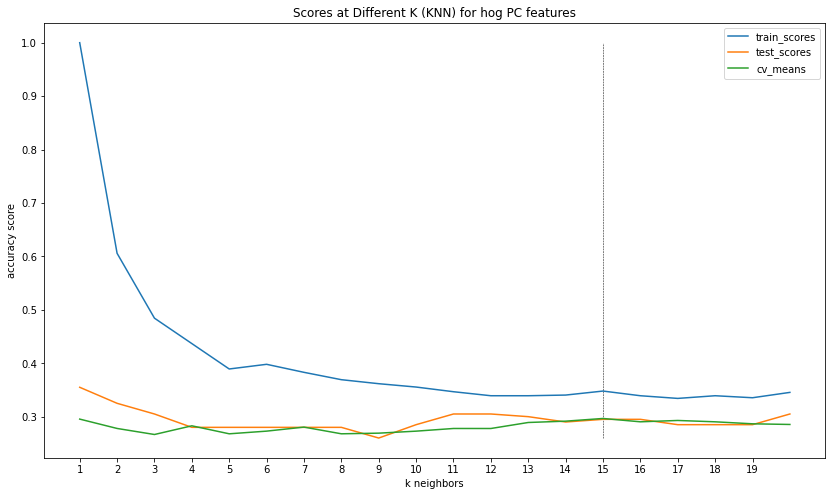

In [42]:
knn_scores_plot(df_knn_scores)

In [43]:
df_knn_scores = knn_scores(data_train=X_train_pc, 
                           data_test=X_test_pc, 
                           neighbors_min=10, neighbors_max=100, neighbors_increment=5)
df_knn_scores

CV means max: 0.2978955696202532
Neighbors: 75


,train_scores,test_scores,cv_means
n_neighbors,,,
10,0.355444,0.285,0.272880
15,0.347935,0.295,0.296614
20,0.345432,0.305,0.285396
25,0.331665,0.295,0.284146
30,0.319149,0.305,0.285348
35,0.321652,0.295,0.280316
40,0.315394,0.300,0.287832
45,0.307885,0.290,0.291598
50,0.312891,0.290,0.287880


CV means max: 0.2978955696202532
Neighbors: 75


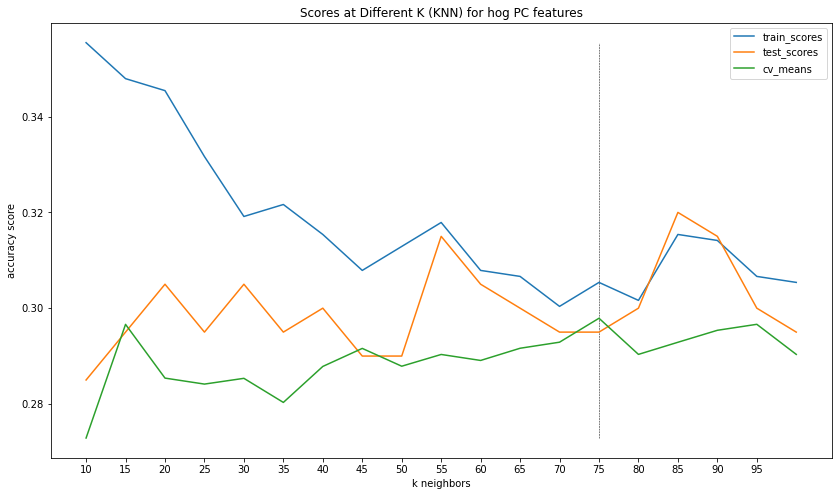

In [45]:
knn_scores_plot(df_knn_scores)

In [46]:
df_knn_scores = knn_scores(data_train=X_train_pc, 
                           data_test=X_test_pc, 
                           neighbors_min=50, neighbors_max=500, neighbors_increment=25)
df_knn_scores

CV means max: 0.30914556962025314
Neighbors: 150


,train_scores,test_scores,cv_means
n_neighbors,,,
50,0.312891,0.290,0.287880
75,0.305382,0.295,0.297896
100,0.305382,0.295,0.290348
125,0.314143,0.290,0.304146
150,0.307885,0.300,0.309146
175,0.312891,0.305,0.302864
200,0.306633,0.295,0.294114
225,0.302879,0.280,0.290364
250,0.295369,0.275,0.276614


CV means max: 0.30914556962025314
Neighbors: 150


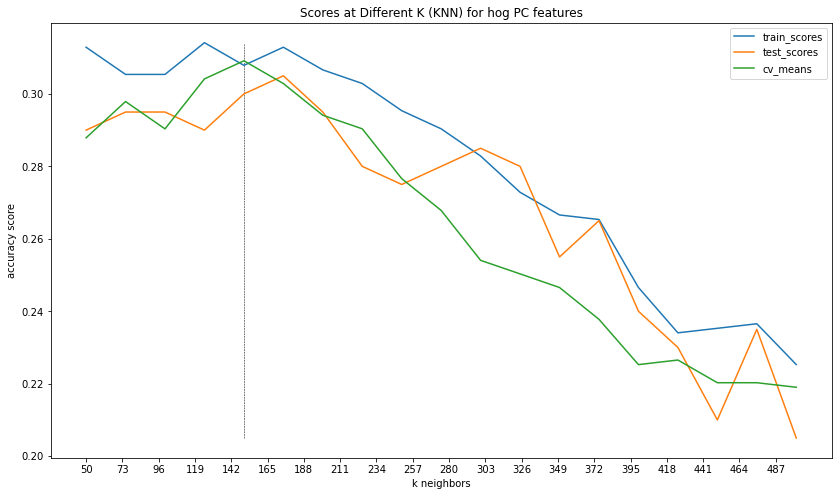

In [48]:
knn_scores_plot(df_knn_scores)

In [49]:
df_knn_scores = knn_scores(data_train=X_train_pc, 
                           data_test=X_test_pc, 
                           neighbors_min=10, neighbors_max=700, neighbors_increment=10)
df_knn_scores

CV means max: 0.31412974683544304
Neighbors: 160


,train_scores,test_scores,cv_means
n_neighbors,,,
10,0.355444,0.285,0.272880
20,0.345432,0.305,0.285396
30,0.319149,0.305,0.285348
40,0.315394,0.300,0.287832
50,0.312891,0.290,0.287880
...,...,...,...
660,0.229036,0.210,0.183972
670,0.222778,0.205,0.150158
680,0.236546,0.235,0.122658


CV means max: 0.31412974683544304
Neighbors: 160


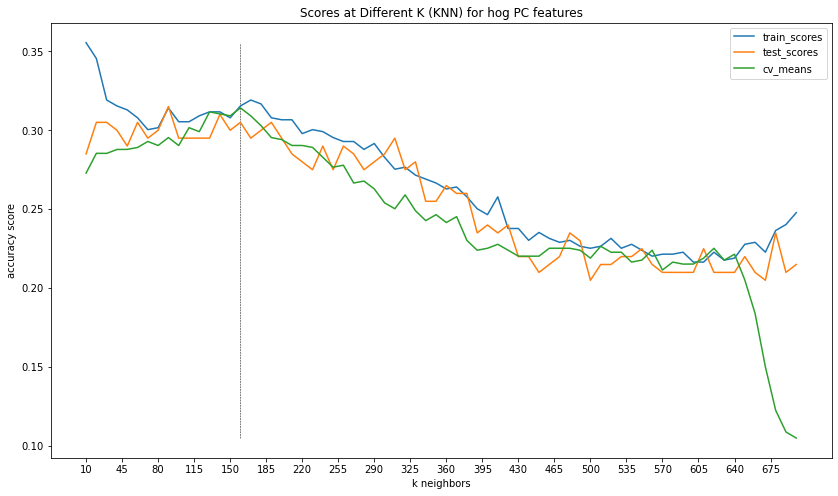

In [50]:
knn_scores_plot(df_knn_scores)

In [54]:
df_knn_scores = knn_scores(data_train=X_train_pc, 
                           data_test=X_test_pc, 
                           neighbors_min=1, neighbors_max=700, neighbors_increment=5)
df_knn_scores

CV means max: 0.3166613924050633
Neighbors: 156


,train_scores,test_scores,cv_means
n_neighbors,,,
1,1.000000,0.355,0.295443
6,0.397997,0.280,0.272911
11,0.346683,0.305,0.277880
16,0.339174,0.295,0.290364
21,0.341677,0.300,0.281646
...,...,...,...
676,0.232791,0.240,0.130174
681,0.232791,0.220,0.123908
686,0.237797,0.205,0.112627


CV means max: 0.3166613924050633
Neighbors: 156


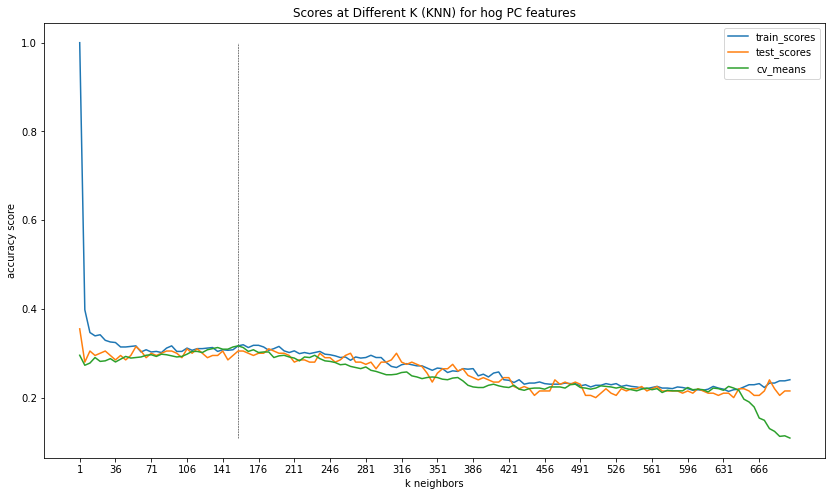

In [55]:
knn_scores_plot(df_knn_scores)